In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Cell 1 — Install required packages

In [1]:
!pip install --upgrade pip
!pip install langchain-groq==0.1.9
!pip install langgraph==0.2.4

## Imports and setup

In [25]:
import os
import sqlite3
from dataclasses import dataclass
from datetime import date
from enum import Enum, auto
from typing import Annotated, List, Literal, Optional, Set, TypedDict

from google.colab import userdata
from IPython.display import Image, display
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.prompts import PromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.tools import tool
from langchain_groq import ChatGroq
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode

## Initialize Chatgroq model
MODEL = "qwen/qwen3-32b"

llm = ChatGroq(temperature=0, model_name=MODEL, api_key=userdata.get("GROQ_API_KEY"))

## Database and Habit Classes

In [26]:
DB_NAME = "habit_tracker.db"

class DayOfWeek(Enum):
    MONDAY = auto()
    TUESDAY = auto()
    WEDNESDAY = auto()
    THURSDAY = auto()
    FRIDAY = auto()
    SATURDAY = auto()
    SUNDAY = auto()

@dataclass
class Habit:
    id: int
    name: str
    repeat_frequency: Set[DayOfWeek]
    tags: List[str]

@dataclass
class DailyHabitEntry:
    id: int
    name: str
    tags: List[str]
    is_completed: bool

## Database functions

In [27]:
def get_connection():
    return sqlite3.connect(DB_NAME)

def create_tables():
    with get_connection() as conn:
        cursor = conn.cursor()
        cursor.execute(
            """
            CREATE TABLE IF NOT EXISTS habits (
                id INTEGER PRIMARY KEY AUTOINCREMENT,
                name TEXT NOT NULL,
                repeat_frequency TEXT NOT NULL,
                tags TEXT NOT NULL
            )
        """
        )
        cursor.execute(
            """
            CREATE TABLE IF NOT EXISTS completions (
                habit_id INTEGER,
                completion_date TEXT,
                PRIMARY KEY (habit_id, completion_date),
                FOREIGN KEY (habit_id) REFERENCES habits (id)
            )
        """
        )
        conn.commit()


## Habit CRUD functions

In [28]:
def list_habits() -> List[Habit]:
    with get_connection() as conn:
        cursor = conn.cursor()
        cursor.execute("SELECT * FROM habits")
        return [
            Habit(
                id,
                name,
                {DayOfWeek[day] for day in freq.split(",")},
                tags.split(","),
            )
            for id, name, freq, tags in cursor.fetchall()
        ]

def habits_for_date(date: date) -> List[DailyHabitEntry]:
    weekday = DayOfWeek(date.weekday() + 1).name
    with get_connection() as conn:
        cursor = conn.cursor()
        cursor.execute(
            """
            SELECT h.id, h.name, h.tags, c.completion_date IS NOT NULL as completed
            FROM habits h
            LEFT JOIN completions c ON h.id = c.habit_id AND c.completion_date = ?
            WHERE instr(h.repeat_frequency, ?) > 0
        """,
            (date.isoformat(), weekday),
        )
        return [
            DailyHabitEntry(id, name, tags.split(","), bool(completed))
            for id, name, tags, completed in cursor.fetchall()
        ]

def complete_habit(habit_id: int, completion_date: date):
    with get_connection() as conn:
        cursor = conn.cursor()
        cursor.execute(
            """
            INSERT OR REPLACE INTO completions (habit_id, completion_date)
            VALUES (?, ?)
        """,
            (habit_id, completion_date.isoformat()),
        )
        conn.commit()

def add_habit(name: str, repeat_frequency: Set[DayOfWeek], tags: List[str] = []) -> int:
    with get_connection() as conn:
        cursor = conn.cursor()
        cursor.execute(
            """
            INSERT INTO habits (name, repeat_frequency, tags)
            VALUES (?, ?, ?)
        """,
            (name, ",".join(day.name for day in repeat_frequency), ",".join(tags)),
        )
        conn.commit()
        return cursor.lastrowid

def show_habits_for_date(date: date):
    print(f"Habits for {date}:")
    for entry in habits_for_date(date):
        status = "Completed" if entry.is_completed else "Not completed"
        print(f"- {entry.name} (ID: {entry.id}): {status}")
        print(f"  Tags: {', '.join(entry.tags)}")


In [29]:
# Initialize DB & Add sample habits
create_tables()

add_habit("Feed the llamas", {DayOfWeek.SATURDAY, DayOfWeek.SUNDAY}, ["diet"])
add_habit(
    "Hit the gym",
    {DayOfWeek.MONDAY, DayOfWeek.WEDNESDAY, DayOfWeek.FRIDAY},
    ["exercise", "fitness"],
)

6

## Define tools for AI agent

In [30]:
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.tools import tool

# --- Tool schemas ---

class CompleteHabitParams(BaseModel):
    habit_id: int = Field(description="Id (number) of the habit e.g. 2")
    day: int = Field(description="Day of the month (1-31) e.g. 18")
    month: int = Field(description="Month of the year (1-12) e.g. 3")
    year: int = Field(description="Year for which to complete the habit e.g. 2024")


class HabitsForDateParams(BaseModel):
    day: int = Field(description="Day of the month (1-31) e.g. 18")
    month: int = Field(description="Month of the year (1-12) e.g. 3")
    year: int = Field(description="Year for which to complete the habit e.g. 2024")


class AddHabitParams(BaseModel):
    name: str = Field(description="Name of the habit")
    repeat_frequency: Set[DayOfWeek] = Field(
        description="Which days of the week the habit should repeat"
    )
    tags: Optional[List[str]] = Field(
        description="Optional list of tags for this habit"
    )

# --- Tool functions ---

@tool(args_schema=CompleteHabitParams)
def complete_habit_tool(habit_id: int, day: int, month: int, year: int):
    """Completes a habit for a specific date."""
    completion_date = date(year, month, day)
    complete_habit(habit_id, completion_date)


@tool(args_schema=HabitsForDateParams)
def habits_for_date_tool(day: int, month: int, year: int):
    """Returns a list of habits for a given date."""
    return habits_for_date(date(year, month, day))


@tool(args_schema=AddHabitParams)
def add_habit_tool(name: str, repeat_frequency: Set[DayOfWeek], tags: List[str] = []):
    """Adds a new habit with specific repeat frequency. Returns the ID of the habit."""
    return add_habit(name, repeat_frequency, tags)

# --- Bind tools to LLM ---

tools = [complete_habit_tool, habits_for_date_tool, add_habit_tool]
llm = llm.bind_tools(tools)


## Build the Graph

In [31]:
from typing import TypedDict, Annotated, List, Literal
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode
from langgraph.graph import END, StateGraph
from langchain_core.prompts import PromptTemplate
from langchain_core.messages import HumanMessage, SystemMessage

# --- State ---
class AppState(TypedDict):
    messages: Annotated[list, add_messages]
    habits: List[Habit]

# --- System template ---
SYSTEM_TEMPLATE = PromptTemplate.from_template(
    """Current habits
{habits}
"""
)

# --- Nodes ---
def update_habits(state: AppState):
    return {"habits": list_habits()}


def call_model(state: AppState):
    messages = state["messages"]
    first_message = messages[0]
    system_message = SystemMessage(SYSTEM_TEMPLATE.format(habits=state["habits"]))
    if first_message.type == "system":
        messages[0] = system_message
    else:
        messages.insert(0, system_message)
    response = llm.invoke(messages)
    return {"messages": [response]}


tool_node = ToolNode(tools)

# --- Edges ---
def should_continue(state: AppState) -> Literal["tools", END]:
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return END

# --- Graph ---
graph = StateGraph(AppState)

graph.add_node("update_habits", update_habits)
graph.add_node("agent", call_model)
graph.add_node("tools", tool_node)

graph.add_edge("update_habits", "agent")
graph.add_conditional_edges("agent", should_continue)
graph.add_edge("tools", "update_habits")

graph.set_entry_point("update_habits")


## Compile the Graph

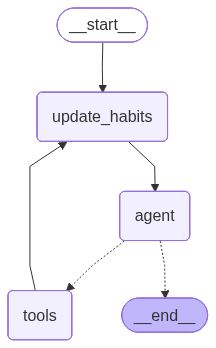

In [32]:
from langgraph.checkpoint.memory import MemorySaver
checkpointer = MemorySaver()
app = graph.compile(checkpointer=checkpointer)

# Optional: visualize the graph
display(Image(app.get_graph().draw_mermaid_png()))

## Chat with the Graph

In [33]:
config = {"configurable": {"thread_id": 42}}

# Example: complete a habit
state = app.invoke(
    {"messages": [HumanMessage(content="Complete the workout for August 14th 2024")]},
    config=config,
)

# Show habits state
state["habits"]

[Habit(id=1, name='Feed the llamas', repeat_frequency={<DayOfWeek.SATURDAY: 6>, <DayOfWeek.SUNDAY: 7>}, tags=['diet']),
 Habit(id=2, name='Hit the gym', repeat_frequency={<DayOfWeek.FRIDAY: 5>, <DayOfWeek.WEDNESDAY: 3>, <DayOfWeek.MONDAY: 1>}, tags=['exercise', 'fitness']),
 Habit(id=3, name='Feed the llamas', repeat_frequency={<DayOfWeek.SATURDAY: 6>, <DayOfWeek.SUNDAY: 7>}, tags=['diet']),
 Habit(id=4, name='Hit the gym', repeat_frequency={<DayOfWeek.FRIDAY: 5>, <DayOfWeek.WEDNESDAY: 3>, <DayOfWeek.MONDAY: 1>}, tags=['exercise', 'fitness']),
 Habit(id=5, name='Feed the llamas', repeat_frequency={<DayOfWeek.SATURDAY: 6>, <DayOfWeek.SUNDAY: 7>}, tags=['diet']),
 Habit(id=6, name='Hit the gym', repeat_frequency={<DayOfWeek.FRIDAY: 5>, <DayOfWeek.WEDNESDAY: 3>, <DayOfWeek.MONDAY: 1>}, tags=['exercise', 'fitness'])]

In [34]:
# Print Messages
for m in state["messages"]:
    m.pretty_print()

================================ System Message ================================

Current habits
[Habit(id=1, name='Feed the llamas', repeat_frequency={<DayOfWeek.SATURDAY: 6>, <DayOfWeek.SUNDAY: 7>}, tags=['diet']), Habit(id=2, name='Hit the gym', repeat_frequency={<DayOfWeek.FRIDAY: 5>, <DayOfWeek.WEDNESDAY: 3>, <DayOfWeek.MONDAY: 1>}, tags=['exercise', 'fitness']), Habit(id=3, name='Feed the llamas', repeat_frequency={<DayOfWeek.SATURDAY: 6>, <DayOfWeek.SUNDAY: 7>}, tags=['diet']), Habit(id=4, name='Hit the gym', repeat_frequency={<DayOfWeek.FRIDAY: 5>, <DayOfWeek.WEDNESDAY: 3>, <DayOfWeek.MONDAY: 1>}, tags=['exercise', 'fitness']), Habit(id=5, name='Feed the llamas', repeat_frequency={<DayOfWeek.SATURDAY: 6>, <DayOfWeek.SUNDAY: 7>}, tags=['diet']), Habit(id=6, name='Hit the gym', repeat_frequency={<DayOfWeek.FRIDAY: 5>, <DayOfWeek.WEDNESDAY: 3>, <DayOfWeek.MONDAY: 1>}, tags=['exercise', 'fitness'])]

================================ Human Message =================================



In [35]:
# Add a New Habit
state = app.invoke(
    {"messages": [HumanMessage(content="Add a new habit for Reading a book every weekday #learning")]},
    config=config,
)

for m in state["messages"]:
    m.pretty_print()


================================ System Message ================================

Current habits
[Habit(id=1, name='Feed the llamas', repeat_frequency={<DayOfWeek.SATURDAY: 6>, <DayOfWeek.SUNDAY: 7>}, tags=['diet']), Habit(id=2, name='Hit the gym', repeat_frequency={<DayOfWeek.FRIDAY: 5>, <DayOfWeek.WEDNESDAY: 3>, <DayOfWeek.MONDAY: 1>}, tags=['exercise', 'fitness']), Habit(id=3, name='Feed the llamas', repeat_frequency={<DayOfWeek.SATURDAY: 6>, <DayOfWeek.SUNDAY: 7>}, tags=['diet']), Habit(id=4, name='Hit the gym', repeat_frequency={<DayOfWeek.FRIDAY: 5>, <DayOfWeek.WEDNESDAY: 3>, <DayOfWeek.MONDAY: 1>}, tags=['exercise', 'fitness']), Habit(id=5, name='Feed the llamas', repeat_frequency={<DayOfWeek.SATURDAY: 6>, <DayOfWeek.SUNDAY: 7>}, tags=['diet']), Habit(id=6, name='Hit the gym', repeat_frequency={<DayOfWeek.FRIDAY: 5>, <DayOfWeek.WEDNESDAY: 3>, <DayOfWeek.MONDAY: 1>}, tags=['exercise', 'fitness']), Habit(id=7, name='Reading a book', repeat_frequency={<DayOfWeek.WEDNESDAY: 3>, <Day

In [36]:
list_habits()

[Habit(id=1, name='Feed the llamas', repeat_frequency={<DayOfWeek.SATURDAY: 6>, <DayOfWeek.SUNDAY: 7>}, tags=['diet']),
 Habit(id=2, name='Hit the gym', repeat_frequency={<DayOfWeek.FRIDAY: 5>, <DayOfWeek.WEDNESDAY: 3>, <DayOfWeek.MONDAY: 1>}, tags=['exercise', 'fitness']),
 Habit(id=3, name='Feed the llamas', repeat_frequency={<DayOfWeek.SATURDAY: 6>, <DayOfWeek.SUNDAY: 7>}, tags=['diet']),
 Habit(id=4, name='Hit the gym', repeat_frequency={<DayOfWeek.FRIDAY: 5>, <DayOfWeek.WEDNESDAY: 3>, <DayOfWeek.MONDAY: 1>}, tags=['exercise', 'fitness']),
 Habit(id=5, name='Feed the llamas', repeat_frequency={<DayOfWeek.SATURDAY: 6>, <DayOfWeek.SUNDAY: 7>}, tags=['diet']),
 Habit(id=6, name='Hit the gym', repeat_frequency={<DayOfWeek.FRIDAY: 5>, <DayOfWeek.WEDNESDAY: 3>, <DayOfWeek.MONDAY: 1>}, tags=['exercise', 'fitness']),
 Habit(id=7, name='Reading a book', repeat_frequency={<DayOfWeek.WEDNESDAY: 3>, <DayOfWeek.TUESDAY: 2>, <DayOfWeek.THURSDAY: 4>, <DayOfWeek.FRIDAY: 5>, <DayOfWeek.MONDAY: 1>},

## Show Scheduled Habits for a Date

In [37]:
state = app.invoke(
    {"messages": [HumanMessage(content="Show the scheduled habits for 14 August 2024")]},
    config=config,
)

print(state["messages"][-1].content)

show_habits_for_date(date(2024, 8, 14))

Here are the habits scheduled for **August 14, 2024**:

1. **Hit the gym**  
   - Tags: `exercise`, `fitness`  
   - Status: ✅ Completed (Habit ID 2)  

2. **Hit the gym**  
   - Tags: `exercise`, `fitness`  
   - Status: ❌ Not completed (Habit ID 4)  

3. **Hit the gym**  
   - Tags: `exercise`, `fitness`  
   - Status: ❌ Not completed (Habit ID 6)  

4. **Reading a book**  
   - Tags: `learning`  
   - Status: ❌ Not completed (Habit ID 7)  

---

**Note:** There are duplicate "Hit the gym" habits (IDs 2, 4, 6). This might be unintentional. Would you like to merge or delete duplicates to simplify tracking?
Habits for 2024-08-14:
- Hit the gym (ID: 2): Completed
  Tags: exercise, fitness
- Hit the gym (ID: 4): Not completed
  Tags: exercise, fitness
- Hit the gym (ID: 6): Not completed
  Tags: exercise, fitness
- Reading a book (ID: 7): Not completed
  Tags: learning
